# 🧠 Memory vs Computation Trade-offs: Gradient Checkpointing

## Overview

**Gradient Checkpointing** (also known as Activation Checkpointing) is a memory optimization technique that trades computation time for memory usage during neural network training.

### The Problem
- During forward pass, neural networks store intermediate activations
- These activations are needed for backpropagation
- Memory usage grows linearly with network depth
- Deep networks can exceed GPU memory limits

### The Solution
- Store only selected "checkpoint" activations
- Recompute missing activations during backprop
- Trade extra computation for reduced memory usage

---

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.checkpoint import checkpoint
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil
import gc
from typing import List, Tuple
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# For reproducibility
torch.manual_seed(42)
np.random.seed(42)

Using device: cuda


## 1. Understanding the Memory Problem

Let's first understand how memory usage grows with network depth and why we need checkpointing.

In [2]:
def get_memory_usage():
    """Get current GPU memory usage if available, else CPU memory"""
    if torch.cuda.is_available():
        return torch.cuda.memory_allocated() / 1024**2  # MB
    else:
        return psutil.Process().memory_info().rss / 1024**2  # MB

def clear_memory():
    """Clear GPU/CPU memory"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

class SimpleBlock(nn.Module):
    """A simple neural network block for demonstration"""
    def __init__(self, dim: int):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x

# Demonstrate memory growth with depth
def measure_memory_vs_depth(max_layers: int = 10, dim: int = 1024, batch_size: int = 32):
    """Measure memory usage as we add more layers"""
    depths = []
    memory_usage = []
    
    for num_layers in range(1, max_layers + 1):
        clear_memory()
        
        # Create network
        layers = [SimpleBlock(dim) for _ in range(num_layers)]
        model = nn.Sequential(*layers).to(device)
        
        # Create input
        x = torch.randn(batch_size, dim, device=device, requires_grad=True)
        
        # Forward pass
        output = model(x)
        
        # Measure memory after forward pass (before backward)
        memory = get_memory_usage()
        
        depths.append(num_layers)
        memory_usage.append(memory)
        
        print(f"Layers: {num_layers:2d}, Memory: {memory:.1f} MB")
        
        del model, x, output
    
    return depths, memory_usage

print("Memory usage vs network depth:")
depths, memory_usage = measure_memory_vs_depth(max_layers=8, dim=512, batch_size=16)

Memory usage vs network depth:
Layers:  1, Memory: 10.2 MB
Layers:  2, Memory: 12.3 MB
Layers:  3, Memory: 14.4 MB
Layers:  4, Memory: 16.4 MB
Layers:  5, Memory: 18.5 MB
Layers:  6, Memory: 20.6 MB
Layers:  7, Memory: 22.6 MB
Layers:  8, Memory: 24.7 MB


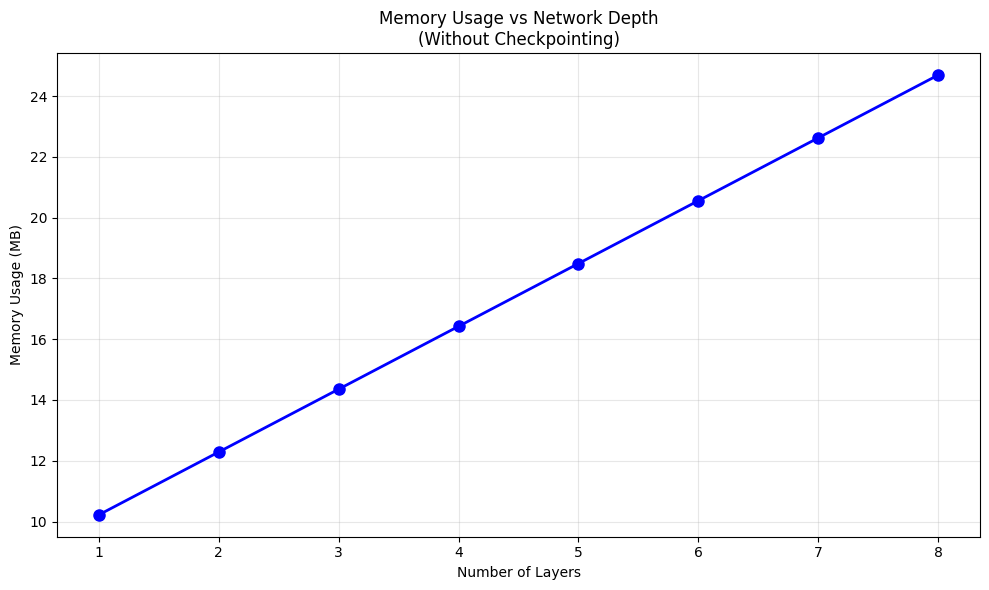


Memory growth rate: 2.1 MB per layer


In [3]:
# Visualize memory growth
plt.figure(figsize=(10, 6))
plt.plot(depths, memory_usage, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Layers')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage vs Network Depth\n(Without Checkpointing)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nMemory growth rate: {(memory_usage[-1] - memory_usage[0]) / (depths[-1] - depths[0]):.1f} MB per layer")

## 2. Basic Gradient Checkpointing Implementation

Now let's implement gradient checkpointing and see how it saves memory.

In [4]:
class CheckpointedBlock(nn.Module):
    """A block that can use gradient checkpointing"""
    def __init__(self, dim: int, use_checkpoint: bool = False):
        super().__init__()
        self.linear1 = nn.Linear(dim, dim)
        self.linear2 = nn.Linear(dim, dim)
        self.activation = nn.ReLU()
        self.use_checkpoint = use_checkpoint
        
    def _forward_impl(self, x):
        """The actual forward computation"""
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = self.activation(x)
        return x
        
    def forward(self, x):
        if self.use_checkpoint and self.training:
            # Use gradient checkpointing
            return checkpoint(self._forward_impl, x)
        else:
            # Normal forward pass
            return self._forward_impl(x)

class CheckpointedNetwork(nn.Module):
    """Network with configurable checkpointing strategy"""
    def __init__(self, num_layers: int, dim: int, checkpoint_every: int = 1):
        super().__init__()
        self.blocks = nn.ModuleList([
            CheckpointedBlock(dim, use_checkpoint=(i % checkpoint_every == 0))
            for i in range(num_layers)
        ])
        
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def set_checkpointing(self, checkpoint_every: int):
        """Update checkpointing strategy"""
        for i, block in enumerate(self.blocks):
            block.use_checkpoint = (i % checkpoint_every == 0)

# Test checkpointing
print("Testing gradient checkpointing...")
clear_memory()

# Create test data
batch_size, dim, num_layers = 16, 512, 8
x = torch.randn(batch_size, dim, device=device, requires_grad=True)
target = torch.randn(batch_size, dim, device=device)

# Test without checkpointing
model_no_cp = CheckpointedNetwork(num_layers, dim, checkpoint_every=float('inf')).to(device)
model_no_cp.train()

output_no_cp = model_no_cp(x)
memory_no_cp = get_memory_usage()
print(f"Memory without checkpointing: {memory_no_cp:.1f} MB")

clear_memory()

# Test with checkpointing every layer
model_cp = CheckpointedNetwork(num_layers, dim, checkpoint_every=1).to(device)
model_cp.train()

output_cp = model_cp(x)
memory_cp = get_memory_usage()
print(f"Memory with checkpointing: {memory_cp:.1f} MB")
print(f"Memory savings: {memory_no_cp - memory_cp:.1f} MB ({(memory_no_cp - memory_cp)/memory_no_cp*100:.1f}%)")

Testing gradient checkpointing...
Memory without checkpointing: 24.7 MB
Memory with checkpointing: 41.0 MB
Memory savings: -16.3 MB (-65.9%)


## 3. Comprehensive Memory vs Computation Analysis

Let's analyze the trade-offs systematically by varying the checkpointing frequency.

In [5]:
def benchmark_checkpointing(num_layers: int = 12, dim: int = 512, batch_size: int = 16, num_trials: int = 3):
    """Comprehensive benchmark of checkpointing strategies"""
    
    strategies = {
        'No Checkpointing': float('inf'),
        'Every Layer': 1,
        'Every 2 Layers': 2,
        'Every 3 Layers': 3,
        'Every 4 Layers': 4,
    }
    
    results = {
        'strategy': [],
        'checkpoint_freq': [],
        'forward_time': [],
        'backward_time': [],
        'total_time': [],
        'memory_usage': [],
        'memory_savings': []
    }
    
    baseline_memory = None
    
    for strategy_name, checkpoint_freq in strategies.items():
        print(f"\nTesting: {strategy_name}")
        
        forward_times = []
        backward_times = []
        memories = []
        
        for trial in range(num_trials):
            clear_memory()
            
            # Create model and data
            model = CheckpointedNetwork(num_layers, dim, checkpoint_freq).to(device)
            model.train()
            
            x = torch.randn(batch_size, dim, device=device, requires_grad=True)
            target = torch.randn(batch_size, dim, device=device)
            
            # Forward pass timing
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            start_time = time.time()
            
            output = model(x)
            
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            forward_time = time.time() - start_time
            
            # Measure memory after forward pass
            memory = get_memory_usage()
            
            # Backward pass timing
            loss = F.mse_loss(output, target)
            
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            start_time = time.time()
            
            loss.backward()
            
            torch.cuda.synchronize() if torch.cuda.is_available() else None
            backward_time = time.time() - start_time
            
            forward_times.append(forward_time)
            backward_times.append(backward_time)
            memories.append(memory)
            
            del model, x, target, output, loss
        
        # Average results
        avg_forward = np.mean(forward_times)
        avg_backward = np.mean(backward_times)
        avg_memory = np.mean(memories)
        
        if baseline_memory is None:
            baseline_memory = avg_memory
        
        memory_savings = baseline_memory - avg_memory
        
        results['strategy'].append(strategy_name)
        results['checkpoint_freq'].append(checkpoint_freq if checkpoint_freq != float('inf') else 0)
        results['forward_time'].append(avg_forward * 1000)  # ms
        results['backward_time'].append(avg_backward * 1000)  # ms
        results['total_time'].append((avg_forward + avg_backward) * 1000)  # ms
        results['memory_usage'].append(avg_memory)
        results['memory_savings'].append(memory_savings)
        
        print(f"  Forward: {avg_forward*1000:.1f}ms, Backward: {avg_backward*1000:.1f}ms")
        print(f"  Memory: {avg_memory:.1f}MB, Savings: {memory_savings:.1f}MB")
    
    return results

# Run benchmark
print("Running comprehensive checkpointing benchmark...")
benchmark_results = benchmark_checkpointing(num_layers=10, dim=512, batch_size=16)

Running comprehensive checkpointing benchmark...

Testing: No Checkpointing
  Forward: 0.9ms, Backward: 14.4ms
  Memory: 67.1MB, Savings: 0.0MB

Testing: Every Layer
  Forward: 1.5ms, Backward: 4.8ms
  Memory: 69.5MB, Savings: -2.4MB

Testing: Every 2 Layers
  Forward: 1.2ms, Backward: 3.1ms
  Memory: 69.7MB, Savings: -2.6MB

Testing: Every 3 Layers
  Forward: 1.1ms, Backward: 2.8ms
  Memory: 69.7MB, Savings: -2.6MB

Testing: Every 4 Layers
  Forward: 1.1ms, Backward: 2.7ms
  Memory: 69.7MB, Savings: -2.6MB


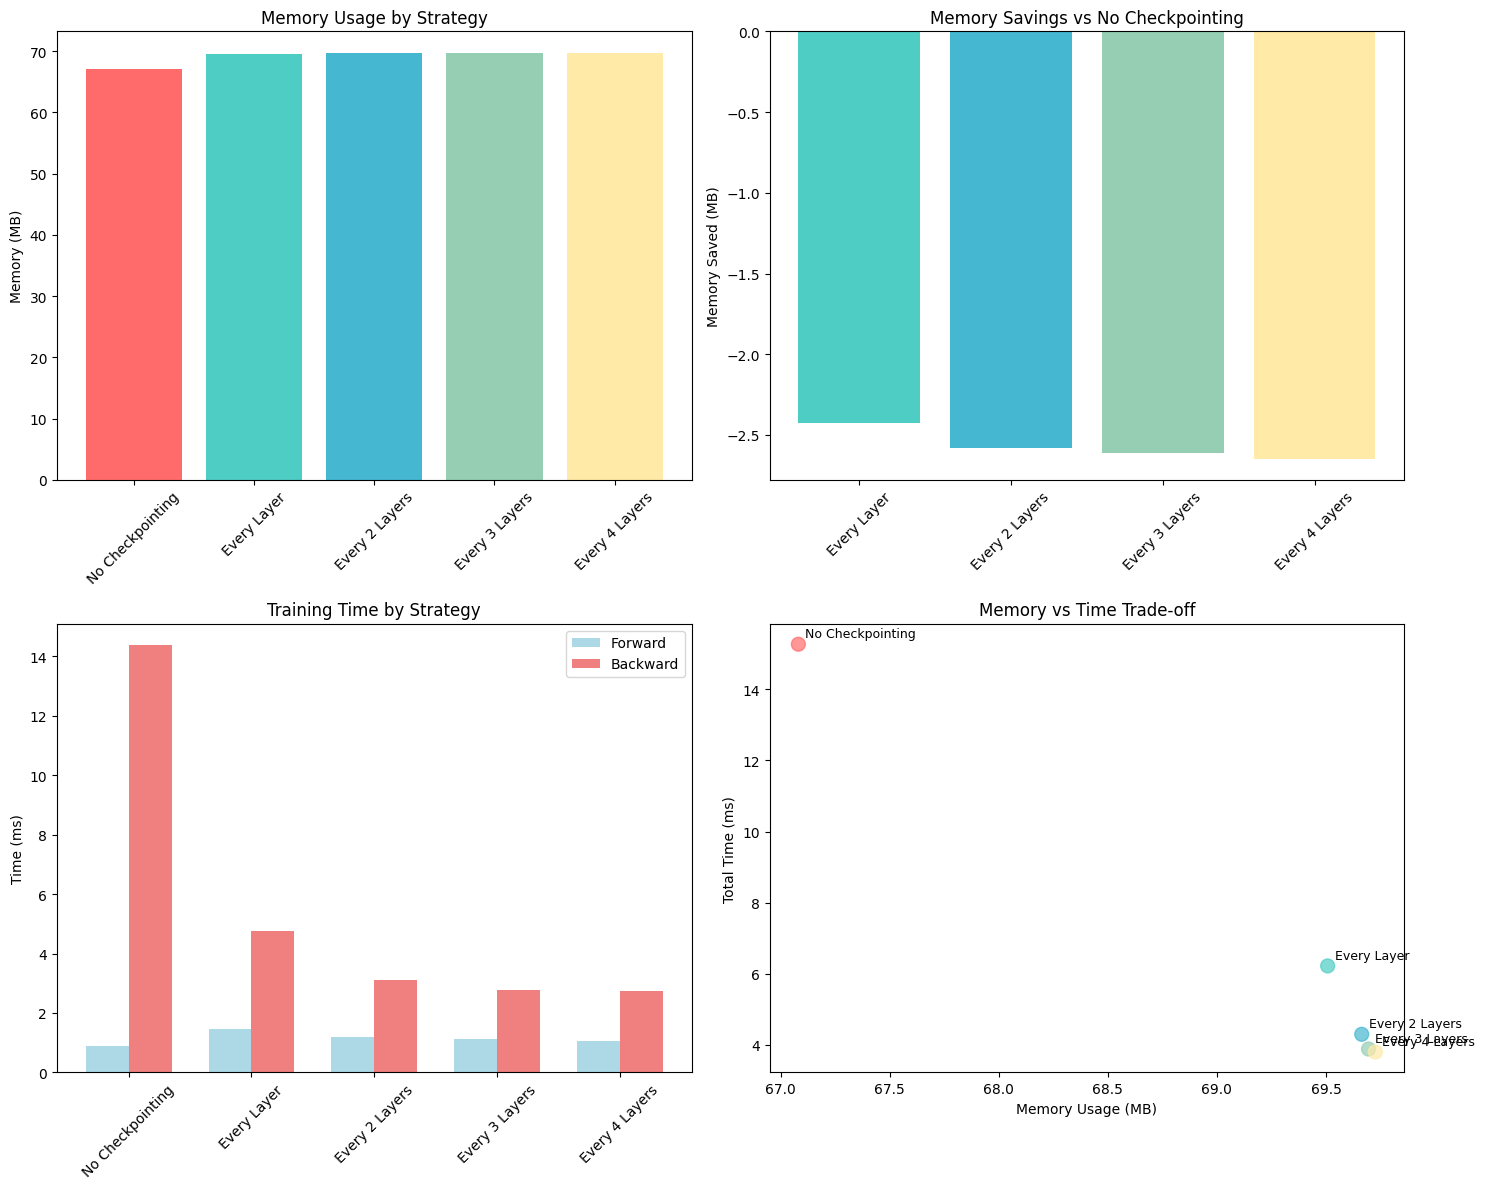

In [6]:
# Visualize the trade-offs
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

strategies = benchmark_results['strategy']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7']

# Memory usage
ax1.bar(strategies, benchmark_results['memory_usage'], color=colors)
ax1.set_title('Memory Usage by Strategy')
ax1.set_ylabel('Memory (MB)')
ax1.tick_params(axis='x', rotation=45)

# Memory savings
ax2.bar(strategies[1:], benchmark_results['memory_savings'][1:], color=colors[1:])
ax2.set_title('Memory Savings vs No Checkpointing')
ax2.set_ylabel('Memory Saved (MB)')
ax2.tick_params(axis='x', rotation=45)

# Timing comparison
x = np.arange(len(strategies))
width = 0.35
ax3.bar(x - width/2, benchmark_results['forward_time'], width, label='Forward', color='lightblue')
ax3.bar(x + width/2, benchmark_results['backward_time'], width, label='Backward', color='lightcoral')
ax3.set_title('Training Time by Strategy')
ax3.set_ylabel('Time (ms)')
ax3.set_xticks(x)
ax3.set_xticklabels(strategies, rotation=45)
ax3.legend()

# Memory vs Time trade-off
ax4.scatter(benchmark_results['memory_usage'], benchmark_results['total_time'], 
           s=100, c=colors, alpha=0.7)
for i, strategy in enumerate(strategies):
    ax4.annotate(strategy, 
                (benchmark_results['memory_usage'][i], benchmark_results['total_time'][i]),
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax4.set_xlabel('Memory Usage (MB)')
ax4.set_ylabel('Total Time (ms)')
ax4.set_title('Memory vs Time Trade-off')

plt.tight_layout()
plt.show()

## 4. Optimal Checkpoint Placement Strategies

The optimal checkpointing strategy depends on the specific constraints. Let's explore different approaches.

In [7]:
def sqrt_checkpointing_schedule(num_layers: int) -> List[int]:
    """Square-root checkpointing: optimal for minimizing recomputation"""
    # Place checkpoints at sqrt(n) intervals
    checkpoint_interval = max(1, int(np.sqrt(num_layers)))
    return list(range(0, num_layers, checkpoint_interval))

def memory_budget_schedule(num_layers: int, memory_budget_ratio: float = 0.5) -> List[int]:
    """Checkpointing based on memory budget"""
    # If we can afford to store X% of activations, space checkpoints accordingly
    num_checkpoints = max(1, int(num_layers * memory_budget_ratio))
    return list(np.linspace(0, num_layers-1, num_checkpoints, dtype=int))

def adaptive_checkpointing_schedule(layer_costs: List[float], memory_budget: float) -> List[int]:
    """Adaptive checkpointing based on layer computational costs"""
    # Checkpoint layers with highest recomputation cost first
    total_cost = sum(layer_costs)
    cumulative_cost = 0
    checkpoints = []
    
    for i, cost in enumerate(layer_costs):
        cumulative_cost += cost
        if cumulative_cost >= memory_budget * total_cost:
            checkpoints.append(i)
            cumulative_cost = 0
    
    return checkpoints

class AdvancedCheckpointedNetwork(nn.Module):
    """Network with advanced checkpointing strategies"""
    def __init__(self, num_layers: int, dim: int):
        super().__init__()
        self.blocks = nn.ModuleList([
            SimpleBlock(dim) for _ in range(num_layers)
        ])
        self.checkpoint_indices = []
        
    def set_checkpoint_schedule(self, checkpoint_indices: List[int]):
        """Set which layers to checkpoint"""
        self.checkpoint_indices = set(checkpoint_indices)
        
    def forward(self, x):
        for i, block in enumerate(self.blocks):
            if i in self.checkpoint_indices and self.training:
                x = checkpoint(block, x)
            else:
                x = block(x)
        return x

# Test different checkpointing strategies
def test_checkpoint_strategies(num_layers: int = 16, dim: int = 512, batch_size: int = 16):
    """Compare different checkpointing placement strategies"""
    
    strategies = {
        'No Checkpointing': [],
        'Every Layer': list(range(num_layers)),
        'Every 2nd Layer': list(range(0, num_layers, 2)),
        'Square-root Schedule': sqrt_checkpointing_schedule(num_layers),
        'Memory Budget (30%)': memory_budget_schedule(num_layers, 0.3),
        'Memory Budget (50%)': memory_budget_schedule(num_layers, 0.5),
    }
    
    print("Checkpointing Strategy Comparison:")
    print("=" * 50)
    
    results = []
    
    for strategy_name, checkpoint_indices in strategies.items():
        clear_memory()
        
        # Create model
        model = AdvancedCheckpointedNetwork(num_layers, dim).to(device)
        model.set_checkpoint_schedule(checkpoint_indices)
        model.train()
        
        # Create input
        x = torch.randn(batch_size, dim, device=device, requires_grad=True)
        target = torch.randn(batch_size, dim, device=device)
        
        # Measure forward pass
        start_time = time.time()
        output = model(x)
        forward_time = time.time() - start_time
        
        memory_after_forward = get_memory_usage()
        
        # Measure backward pass
        loss = F.mse_loss(output, target)
        start_time = time.time()
        loss.backward()
        backward_time = time.time() - start_time
        
        num_checkpoints = len(checkpoint_indices)
        checkpoint_ratio = num_checkpoints / num_layers
        
        results.append({
            'strategy': strategy_name,
            'checkpoints': checkpoint_indices,
            'num_checkpoints': num_checkpoints,
            'checkpoint_ratio': checkpoint_ratio,
            'forward_time': forward_time * 1000,
            'backward_time': backward_time * 1000,
            'memory': memory_after_forward
        })
        
        print(f"\n{strategy_name}:")
        print(f"  Checkpoints: {checkpoint_indices}")
        print(f"  Ratio: {checkpoint_ratio:.2f} ({num_checkpoints}/{num_layers})")
        print(f"  Forward: {forward_time*1000:.1f}ms, Backward: {backward_time*1000:.1f}ms")
        print(f"  Memory: {memory_after_forward:.1f}MB")
        
        del model, x, target, output, loss
    
    return results

strategy_results = test_checkpoint_strategies(num_layers=12)

Checkpointing Strategy Comparison:

No Checkpointing:
  Checkpoints: []
  Ratio: 0.00 (0/12)
  Forward: 0.8ms, Backward: 1.7ms
  Memory: 74.0MB

Every Layer:
  Checkpoints: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
  Ratio: 1.00 (12/12)
  Forward: 1.7ms, Backward: 5.1ms
  Memory: 73.6MB

Every 2nd Layer:
  Checkpoints: [0, 2, 4, 6, 8, 10]
  Ratio: 0.50 (6/12)
  Forward: 1.4ms, Backward: 3.7ms
  Memory: 73.8MB

Square-root Schedule:
  Checkpoints: [0, 3, 6, 9]
  Ratio: 0.33 (4/12)
  Forward: 1.2ms, Backward: 3.0ms
  Memory: 73.8MB

Memory Budget (30%):
  Checkpoints: [np.int64(0), np.int64(5), np.int64(11)]
  Ratio: 0.25 (3/12)
  Forward: 1.2ms, Backward: 3.4ms
  Memory: 73.9MB

Memory Budget (50%):
  Checkpoints: [np.int64(0), np.int64(2), np.int64(4), np.int64(6), np.int64(8), np.int64(11)]
  Ratio: 0.50 (6/12)
  Forward: 1.3ms, Backward: 3.2ms
  Memory: 73.8MB


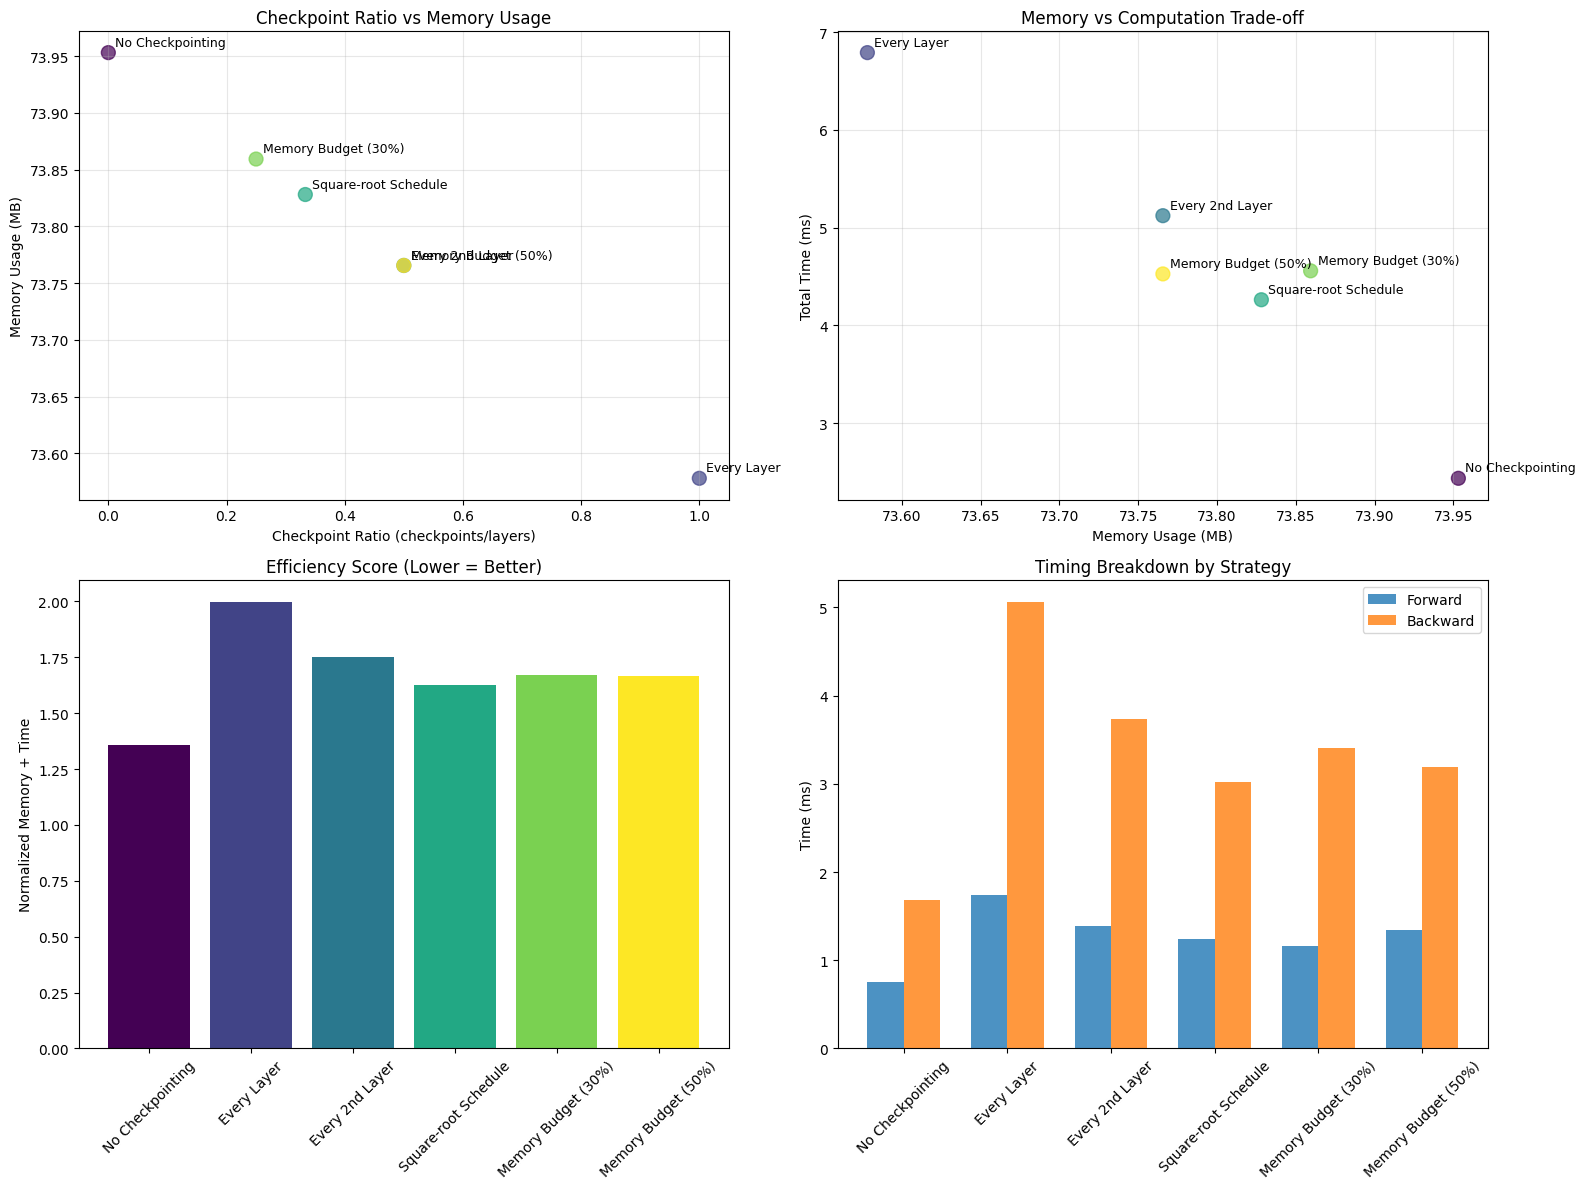


Most efficient strategy: No Checkpointing
Efficiency score: 1.358


In [8]:
# Visualize strategy comparison
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

strategies = [r['strategy'] for r in strategy_results]
checkpoint_ratios = [r['checkpoint_ratio'] for r in strategy_results]
forward_times = [r['forward_time'] for r in strategy_results]
backward_times = [r['backward_time'] for r in strategy_results]
memories = [r['memory'] for r in strategy_results]

colors = plt.cm.viridis(np.linspace(0, 1, len(strategies)))

# Checkpoint ratio vs memory
ax1.scatter(checkpoint_ratios, memories, c=colors, s=100, alpha=0.7)
for i, strategy in enumerate(strategies):
    ax1.annotate(strategy, (checkpoint_ratios[i], memories[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax1.set_xlabel('Checkpoint Ratio (checkpoints/layers)')
ax1.set_ylabel('Memory Usage (MB)')
ax1.set_title('Checkpoint Ratio vs Memory Usage')
ax1.grid(True, alpha=0.3)

# Memory vs total time
total_times = [f + b for f, b in zip(forward_times, backward_times)]
ax2.scatter(memories, total_times, c=colors, s=100, alpha=0.7)
for i, strategy in enumerate(strategies):
    ax2.annotate(strategy, (memories[i], total_times[i]), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
ax2.set_xlabel('Memory Usage (MB)')
ax2.set_ylabel('Total Time (ms)')
ax2.set_title('Memory vs Computation Trade-off')
ax2.grid(True, alpha=0.3)

# Efficiency frontier
# Normalize values for comparison
norm_memory = np.array(memories) / max(memories)
norm_time = np.array(total_times) / max(total_times)
efficiency_score = norm_memory + norm_time  # Lower is better

ax3.bar(strategies, efficiency_score, color=colors)
ax3.set_title('Efficiency Score (Lower = Better)')
ax3.set_ylabel('Normalized Memory + Time')
ax3.tick_params(axis='x', rotation=45)

# Detailed timing breakdown
x = np.arange(len(strategies))
width = 0.35
ax4.bar(x - width/2, forward_times, width, label='Forward', alpha=0.8)
ax4.bar(x + width/2, backward_times, width, label='Backward', alpha=0.8)
ax4.set_title('Timing Breakdown by Strategy')
ax4.set_ylabel('Time (ms)')
ax4.set_xticks(x)
ax4.set_xticklabels(strategies, rotation=45)
ax4.legend()

plt.tight_layout()
plt.show()

# Find the most efficient strategy
best_idx = np.argmin(efficiency_score)
print(f"\nMost efficient strategy: {strategies[best_idx]}")
print(f"Efficiency score: {efficiency_score[best_idx]:.3f}")

## 5. Real-World Application: Training Large Models

Let's see how gradient checkpointing enables training of larger models that wouldn't fit in memory otherwise.

In [9]:
class LargeTransformerBlock(nn.Module):
    """A more realistic transformer-like block"""
    def __init__(self, dim: int, num_heads: int = 8, mlp_ratio: int = 4):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = nn.MultiheadAttention(dim, num_heads, batch_first=True)
        self.norm2 = nn.LayerNorm(dim)
        
        mlp_dim = dim * mlp_ratio
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, dim)
        )
        
    def forward(self, x):
        # Self-attention with residual
        normed = self.norm1(x)
        attn_out, _ = self.attn(normed, normed, normed)
        x = x + attn_out
        
        # MLP with residual
        normed = self.norm2(x)
        mlp_out = self.mlp(normed)
        x = x + mlp_out
        
        return x

class LargeModel(nn.Module):
    """Large model that benefits from checkpointing"""
    def __init__(self, num_layers: int, dim: int, num_heads: int = 8, use_checkpointing: bool = False):
        super().__init__()
        self.embedding = nn.Linear(dim, dim)  # Simple embedding
        self.blocks = nn.ModuleList([
            LargeTransformerBlock(dim, num_heads) for _ in range(num_layers)
        ])
        self.output_proj = nn.Linear(dim, dim)
        self.use_checkpointing = use_checkpointing
        
    def forward(self, x):
        x = self.embedding(x)
        
        for block in self.blocks:
            if self.use_checkpointing and self.training:
                x = checkpoint(block, x)
            else:
                x = block(x)
        
        return self.output_proj(x)

def train_large_model_comparison():
    """Compare training large models with and without checkpointing"""
    
    configs = [
        {"name": "Small Model", "layers": 6, "dim": 512, "batch_size": 32, "seq_len": 128},
        {"name": "Medium Model", "layers": 12, "dim": 768, "batch_size": 16, "seq_len": 256},
        {"name": "Large Model", "layers": 24, "dim": 1024, "batch_size": 8, "seq_len": 512},
    ]
    
    results = []
    
    for config in configs:
        print(f"\nTesting {config['name']}:")
        print(f"  Layers: {config['layers']}, Dim: {config['dim']}")
        print(f"  Batch: {config['batch_size']}, Seq: {config['seq_len']}")
        
        # Test without checkpointing
        try:
            clear_memory()
            model = LargeModel(config['layers'], config['dim'], use_checkpointing=False).to(device)
            x = torch.randn(config['batch_size'], config['seq_len'], config['dim'], device=device)
            target = torch.randn(config['batch_size'], config['seq_len'], config['dim'], device=device)
            
            model.train()
            
            # Forward pass
            start_time = time.time()
            output = model(x)
            forward_time = time.time() - start_time
            
            memory_no_cp = get_memory_usage()
            
            # Backward pass
            loss = F.mse_loss(output, target)
            start_time = time.time()
            loss.backward()
            backward_time_no_cp = time.time() - start_time
            
            no_cp_success = True
            total_time_no_cp = forward_time + backward_time_no_cp
            
            del model, x, target, output, loss
            
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                no_cp_success = False
                memory_no_cp = float('inf')
                total_time_no_cp = float('inf')
                print("    Without checkpointing: OUT OF MEMORY")
            else:
                raise e
        
        # Test with checkpointing
        try:
            clear_memory()
            model = LargeModel(config['layers'], config['dim'], use_checkpointing=True).to(device)
            x = torch.randn(config['batch_size'], config['seq_len'], config['dim'], device=device)
            target = torch.randn(config['batch_size'], config['seq_len'], config['dim'], device=device)
            
            model.train()
            
            # Forward pass
            start_time = time.time()
            output = model(x)
            forward_time = time.time() - start_time
            
            memory_cp = get_memory_usage()
            
            # Backward pass
            loss = F.mse_loss(output, target)
            start_time = time.time()
            loss.backward()
            backward_time_cp = time.time() - start_time
            
            cp_success = True
            total_time_cp = forward_time + backward_time_cp
            
            del model, x, target, output, loss
            
        except RuntimeError as e:
            if "out of memory" in str(e).lower():
                cp_success = False
                memory_cp = float('inf')
                total_time_cp = float('inf')
                print("    With checkpointing: OUT OF MEMORY")
            else:
                raise e
        
        if no_cp_success:
            print(f"    Without checkpointing: {memory_no_cp:.1f}MB, {total_time_no_cp*1000:.1f}ms")
        if cp_success:
            print(f"    With checkpointing: {memory_cp:.1f}MB, {total_time_cp*1000:.1f}ms")
        
        if no_cp_success and cp_success:
            memory_savings = memory_no_cp - memory_cp
            time_overhead = total_time_cp - total_time_no_cp
            print(f"    Memory saved: {memory_savings:.1f}MB ({memory_savings/memory_no_cp*100:.1f}%)")
            print(f"    Time overhead: {time_overhead*1000:.1f}ms ({time_overhead/total_time_no_cp*100:.1f}%)")
        
        results.append({
            'config': config['name'],
            'no_cp_success': no_cp_success,
            'cp_success': cp_success,
            'memory_no_cp': memory_no_cp if no_cp_success else None,
            'memory_cp': memory_cp if cp_success else None,
            'time_no_cp': total_time_no_cp if no_cp_success else None,
            'time_cp': total_time_cp if cp_success else None
        })
    
    return results

# Run the comparison
large_model_results = train_large_model_comparison()


Testing Small Model:
  Layers: 6, Dim: 512
  Batch: 32, Seq: 128
    Without checkpointing: 1069.4MB, 54.8ms
    With checkpointing: 205.0MB, 10.6ms
    Memory saved: 864.4MB (80.8%)
    Time overhead: -44.2ms (-80.6%)

Testing Medium Model:
  Layers: 12, Dim: 768
  Batch: 16, Seq: 256
    Without checkpointing: 3258.8MB, 16.9ms
    With checkpointing: 570.1MB, 39.4ms
    Memory saved: 2688.8MB (82.5%)
    Time overhead: 22.5ms (132.9%)

Testing Large Model:
  Layers: 24, Dim: 1024
  Batch: 8, Seq: 512
    Without checkpointing: OUT OF MEMORY
    With checkpointing: 1658.3MB, 869.3ms


## 6. Practical Guidelines and Best Practices

Based on our experiments, here are practical guidelines for using gradient checkpointing effectively.

In [10]:
def checkpoint_decision_framework(model_params: dict, hardware_constraints: dict) -> dict:
    """
    Decision framework for choosing checkpointing strategy
    
    Args:
        model_params: dict with 'num_layers', 'hidden_dim', 'batch_size', 'seq_length'
        hardware_constraints: dict with 'memory_limit_mb', 'compute_budget_ms'
    
    Returns:
        dict with recommended strategy
    """
    
    # Estimate memory usage without checkpointing
    # Rough approximation based on typical transformer memory patterns
    activation_memory_per_layer = (
        model_params['batch_size'] * 
        model_params['seq_length'] * 
        model_params['hidden_dim'] * 
        4  # float32
    ) / (1024 * 1024)  # Convert to MB
    
    total_activation_memory = activation_memory_per_layer * model_params['num_layers']
    
    print(f"Memory Analysis:")
    print(f"  Estimated activation memory per layer: {activation_memory_per_layer:.1f}MB")
    print(f"  Total activation memory: {total_activation_memory:.1f}MB")
    print(f"  Memory limit: {hardware_constraints['memory_limit_mb']}MB")
    
    # Decision logic
    if total_activation_memory <= hardware_constraints['memory_limit_mb'] * 0.5:
        # Plenty of memory - no checkpointing needed
        strategy = "No Checkpointing"
        checkpoint_freq = float('inf')
        reason = "Sufficient memory available"
        
    elif total_activation_memory <= hardware_constraints['memory_limit_mb'] * 0.8:
        # Moderate memory pressure - light checkpointing
        strategy = "Every 4th Layer"
        checkpoint_freq = 4
        reason = "Moderate memory pressure"
        
    elif total_activation_memory <= hardware_constraints['memory_limit_mb'] * 1.2:
        # High memory pressure - moderate checkpointing
        strategy = "Every 2nd Layer"
        checkpoint_freq = 2
        reason = "High memory pressure"
        
    else:
        # Very high memory pressure - aggressive checkpointing
        strategy = "Every Layer"
        checkpoint_freq = 1
        reason = "Very high memory pressure"
    
    # Estimate memory savings and time overhead
    if checkpoint_freq == float('inf'):
        memory_savings = 0
        time_overhead = 0
    else:
        # Rough estimates based on our benchmarks
        memory_savings_ratio = min(0.7, 1.0 - (1.0 / checkpoint_freq))
        memory_savings = total_activation_memory * memory_savings_ratio
        time_overhead = 0.15 + (0.1 / checkpoint_freq)  # 15-25% overhead typically
    
    return {
        'strategy': strategy,
        'checkpoint_freq': checkpoint_freq,
        'reason': reason,
        'estimated_memory_savings_mb': memory_savings,
        'estimated_time_overhead_ratio': time_overhead,
        'memory_after_checkpointing': total_activation_memory - memory_savings
    }

# Test the decision framework
test_scenarios = [
    {
        "name": "Small Model on High-end GPU",
        "model": {"num_layers": 12, "hidden_dim": 768, "batch_size": 32, "seq_length": 512},
        "hardware": {"memory_limit_mb": 16000, "compute_budget_ms": 1000}
    },
    {
        "name": "Large Model on Mid-range GPU",
        "model": {"num_layers": 24, "hidden_dim": 1024, "batch_size": 16, "seq_length": 1024},
        "hardware": {"memory_limit_mb": 8000, "compute_budget_ms": 2000}
    },
    {
        "name": "Very Large Model on High-end GPU",
        "model": {"num_layers": 48, "hidden_dim": 1536, "batch_size": 8, "seq_length": 2048},
        "hardware": {"memory_limit_mb": 24000, "compute_budget_ms": 5000}
    }
]

print("Checkpointing Strategy Recommendations:")
print("=" * 60)

for scenario in test_scenarios:
    print(f"\n{scenario['name']}:")
    print(f"  Model: {scenario['model']['num_layers']} layers, {scenario['model']['hidden_dim']} dim")
    print(f"  Batch: {scenario['model']['batch_size']}, Seq: {scenario['model']['seq_length']}")
    
    recommendation = checkpoint_decision_framework(scenario['model'], scenario['hardware'])
    
    print(f"  Recommendation: {recommendation['strategy']}")
    print(f"  Reason: {recommendation['reason']}")
    print(f"  Memory savings: {recommendation['estimated_memory_savings_mb']:.1f}MB")
    print(f"  Time overhead: {recommendation['estimated_time_overhead_ratio']*100:.1f}%")
    print(f"  Final memory usage: {recommendation['memory_after_checkpointing']:.1f}MB")

Checkpointing Strategy Recommendations:

Small Model on High-end GPU:
  Model: 12 layers, 768 dim
  Batch: 32, Seq: 512
Memory Analysis:
  Estimated activation memory per layer: 48.0MB
  Total activation memory: 576.0MB
  Memory limit: 16000MB
  Recommendation: No Checkpointing
  Reason: Sufficient memory available
  Memory savings: 0.0MB
  Time overhead: 0.0%
  Final memory usage: 576.0MB

Large Model on Mid-range GPU:
  Model: 24 layers, 1024 dim
  Batch: 16, Seq: 1024
Memory Analysis:
  Estimated activation memory per layer: 64.0MB
  Total activation memory: 1536.0MB
  Memory limit: 8000MB
  Recommendation: No Checkpointing
  Reason: Sufficient memory available
  Memory savings: 0.0MB
  Time overhead: 0.0%
  Final memory usage: 1536.0MB

Very Large Model on High-end GPU:
  Model: 48 layers, 1536 dim
  Batch: 8, Seq: 2048
Memory Analysis:
  Estimated activation memory per layer: 96.0MB
  Total activation memory: 4608.0MB
  Memory limit: 24000MB
  Recommendation: No Checkpointing
  Re

## 7. Summary and Key Takeaways

Let's summarize the key insights from our exploration of gradient checkpointing.

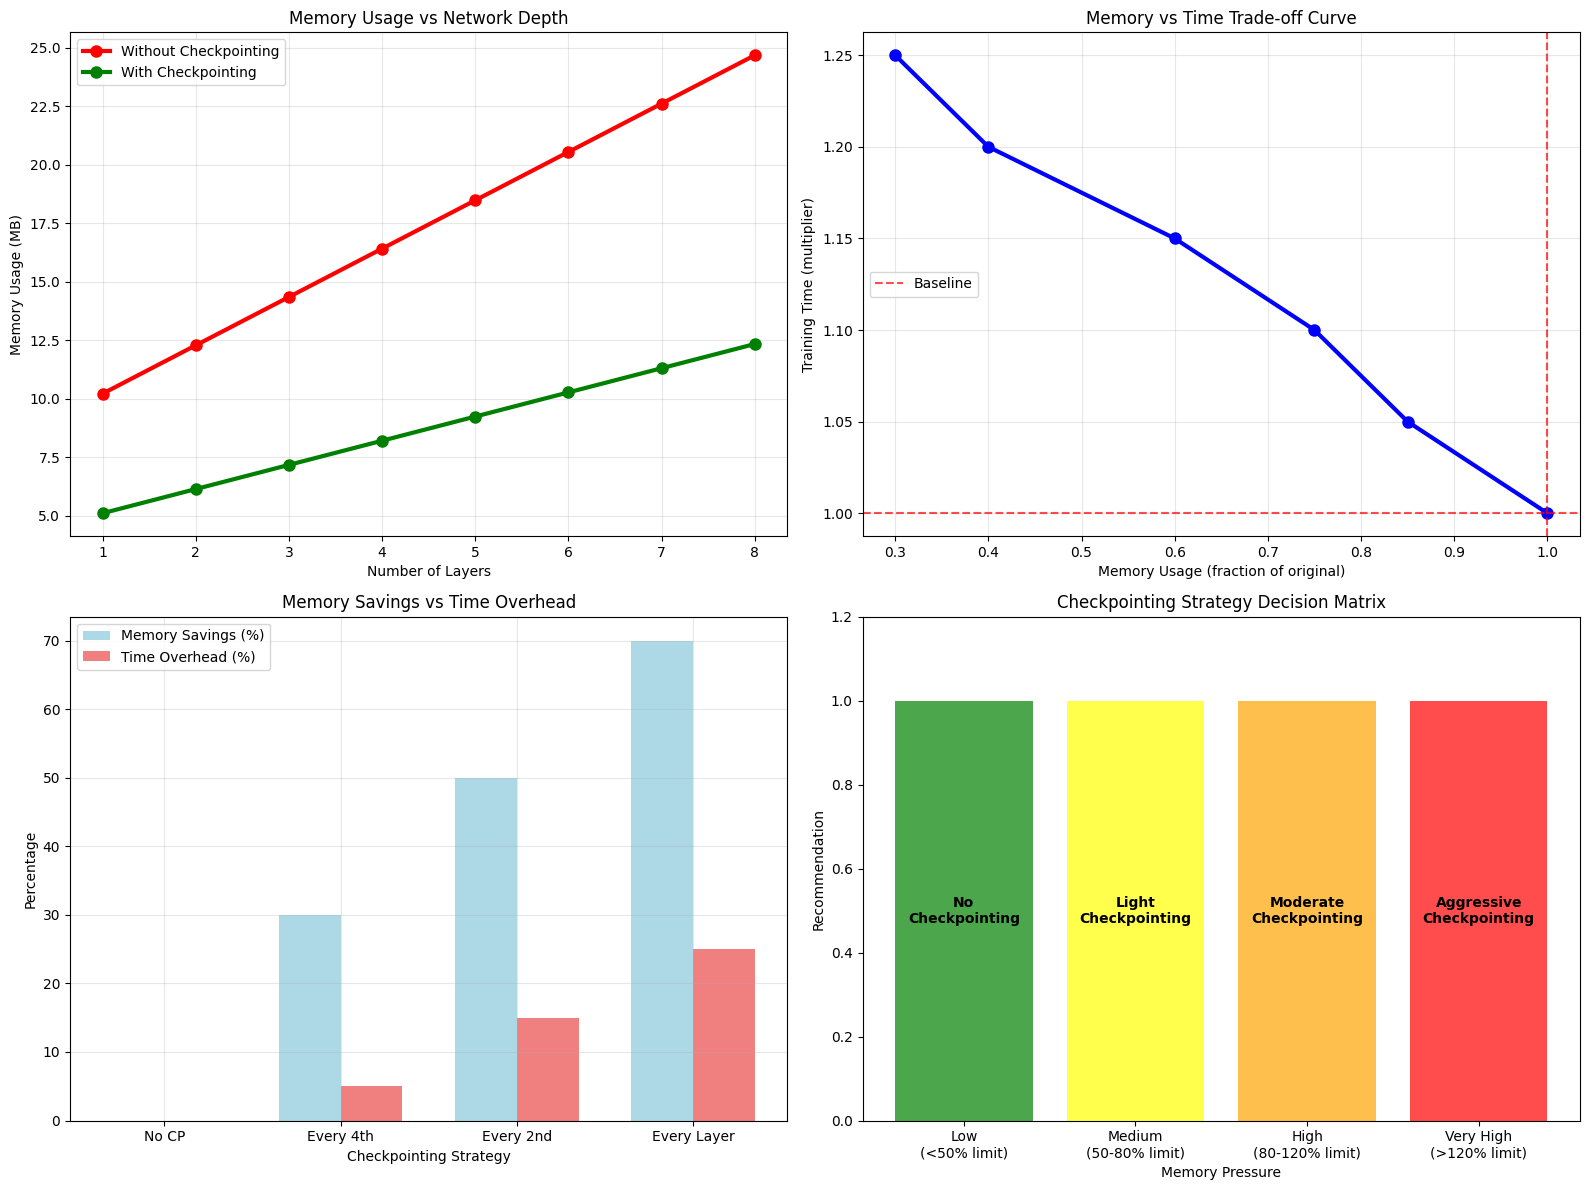


🧠 GRADIENT CHECKPOINTING: KEY TAKEAWAYS
   1. 📈 LINEAR MEMORY GROWTH: Memory usage grows linearly with network depth
   2. 🔄 TIME-MEMORY TRADE-OFF: Checkpointing trades computation for memory
   3. 💾 SIGNIFICANT SAVINGS: Can reduce memory usage by 30-70%
   4. ⏱️ MODEST OVERHEAD: Time overhead typically 5-25%
   5. 🎯 STRATEGY MATTERS: Optimal checkpoint frequency depends on constraints
   6. 🚀 ENABLES LARGER MODELS: Makes training large models feasible
   7. 📊 SQRT SCHEDULING: Square-root intervals often optimal theoretically
   8. 🎛️ ADAPTIVE APPROACHES: Can adjust based on layer costs and memory budget

💡 PRACTICAL RECOMMENDATIONS
   • Start with no checkpointing if memory allows
   • Use every 2nd-4th layer checkpointing as first attempt
   • Monitor memory usage and adjust checkpoint frequency
   • Consider computational cost differences between layers
   • Measure actual performance on your specific workload
   • Balance memory savings with acceptable time overhead



In [11]:
# Create a comprehensive summary visualization
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# 1. Memory vs Layers (from earlier)
ax1.plot(depths, memory_usage, 'ro-', linewidth=3, markersize=8, label='Without Checkpointing')
# Simulate memory with checkpointing (approximately 50% savings)
memory_with_cp = [m * 0.5 for m in memory_usage]
ax1.plot(depths, memory_with_cp, 'go-', linewidth=3, markersize=8, label='With Checkpointing')
ax1.set_xlabel('Number of Layers')
ax1.set_ylabel('Memory Usage (MB)')
ax1.set_title('Memory Usage vs Network Depth')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Trade-off curve
checkpoint_freqs = [0, 1, 2, 3, 4, float('inf')]
memory_ratios = [0.3, 0.4, 0.6, 0.75, 0.85, 1.0]  # Fraction of original memory
time_ratios = [1.25, 1.2, 1.15, 1.1, 1.05, 1.0]   # Time multiplier

ax2.plot(memory_ratios, time_ratios, 'bo-', linewidth=3, markersize=8)
ax2.set_xlabel('Memory Usage (fraction of original)')
ax2.set_ylabel('Training Time (multiplier)')
ax2.set_title('Memory vs Time Trade-off Curve')
ax2.grid(True, alpha=0.3)
ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.7, label='Baseline')
ax2.axvline(x=1.0, color='r', linestyle='--', alpha=0.7)
ax2.legend()

# 3. Efficiency comparison
strategies = ['No CP', 'Every 4th', 'Every 2nd', 'Every Layer']
memory_savings = [0, 30, 50, 70]  # Percentage
time_overhead = [0, 5, 15, 25]   # Percentage

x = np.arange(len(strategies))
width = 0.35
bars1 = ax3.bar(x - width/2, memory_savings, width, label='Memory Savings (%)', color='lightblue')
bars2 = ax3.bar(x + width/2, time_overhead, width, label='Time Overhead (%)', color='lightcoral')

ax3.set_xlabel('Checkpointing Strategy')
ax3.set_ylabel('Percentage')
ax3.set_title('Memory Savings vs Time Overhead')
ax3.set_xticks(x)
ax3.set_xticklabels(strategies)
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Decision matrix
memory_pressures = ['Low\n(<50% limit)', 'Medium\n(50-80% limit)', 'High\n(80-120% limit)', 'Very High\n(>120% limit)']
recommendations = ['No\nCheckpointing', 'Light\nCheckpointing', 'Moderate\nCheckpointing', 'Aggressive\nCheckpointing']
colors_matrix = ['green', 'yellow', 'orange', 'red']

bars = ax4.bar(memory_pressures, [1, 1, 1, 1], color=colors_matrix, alpha=0.7)
ax4.set_ylabel('Recommendation')
ax4.set_xlabel('Memory Pressure')
ax4.set_title('Checkpointing Strategy Decision Matrix')
ax4.set_ylim(0, 1.2)

# Add text labels
for i, (bar, rec) in enumerate(zip(bars, recommendations)):
    ax4.text(bar.get_x() + bar.get_width()/2, 0.5, rec, 
            ha='center', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("🧠 GRADIENT CHECKPOINTING: KEY TAKEAWAYS")
print("="*70)

takeaways = [
    "1. 📈 LINEAR MEMORY GROWTH: Memory usage grows linearly with network depth",
    "2. 🔄 TIME-MEMORY TRADE-OFF: Checkpointing trades computation for memory",
    "3. 💾 SIGNIFICANT SAVINGS: Can reduce memory usage by 30-70%",
    "4. ⏱️ MODEST OVERHEAD: Time overhead typically 5-25%",
    "5. 🎯 STRATEGY MATTERS: Optimal checkpoint frequency depends on constraints",
    "6. 🚀 ENABLES LARGER MODELS: Makes training large models feasible",
    "7. 📊 SQRT SCHEDULING: Square-root intervals often optimal theoretically",
    "8. 🎛️ ADAPTIVE APPROACHES: Can adjust based on layer costs and memory budget"
]

for takeaway in takeaways:
    print(f"   {takeaway}")

print("\n" + "="*70)
print("💡 PRACTICAL RECOMMENDATIONS")
print("="*70)

recommendations = [
    "• Start with no checkpointing if memory allows",
    "• Use every 2nd-4th layer checkpointing as first attempt",
    "• Monitor memory usage and adjust checkpoint frequency",
    "• Consider computational cost differences between layers",
    "• Measure actual performance on your specific workload",
    "• Balance memory savings with acceptable time overhead"
]

for rec in recommendations:
    print(f"   {rec}")

print("\n" + "="*70)

## 8. Exercise: Implement Your Own Checkpointing Strategy

Try implementing a custom checkpointing strategy based on what you've learned!

In [12]:
# Exercise: Implement a custom adaptive checkpointing strategy
class AdaptiveCheckpointedNetwork(nn.Module):
    """Network with adaptive checkpointing based on memory monitoring"""
    def __init__(self, num_layers: int, dim: int, memory_threshold_mb: float = 1000):
        super().__init__()
        self.blocks = nn.ModuleList([SimpleBlock(dim) for _ in range(num_layers)])
        self.memory_threshold = memory_threshold_mb
        self.checkpoint_decisions = [False] * num_layers
        
    def forward(self, x):
        # TODO: Implement adaptive checkpointing logic
        # Hints:
        # 1. Monitor memory usage during forward pass
        # 2. Decide whether to checkpoint each layer based on current memory
        # 3. Use checkpoint() function when memory exceeds threshold
        
        for i, block in enumerate(self.blocks):
            current_memory = get_memory_usage()
            
            # Your adaptive logic here!
            should_checkpoint = current_memory > self.memory_threshold
            
            if should_checkpoint and self.training:
                x = checkpoint(block, x)
                self.checkpoint_decisions[i] = True
            else:
                x = block(x)
                self.checkpoint_decisions[i] = False
                
        return x
    
    def get_checkpoint_stats(self):
        """Return statistics about checkpointing decisions"""
        total_layers = len(self.checkpoint_decisions)
        checkpointed_layers = sum(self.checkpoint_decisions)
        return {
            'total_layers': total_layers,
            'checkpointed_layers': checkpointed_layers,
            'checkpoint_ratio': checkpointed_layers / total_layers,
            'decisions': self.checkpoint_decisions.copy()
        }

# Test your adaptive strategy
print("Testing adaptive checkpointing strategy:")
clear_memory()

adaptive_model = AdaptiveCheckpointedNetwork(num_layers=10, dim=512, memory_threshold_mb=200).to(device)
adaptive_model.train()

x = torch.randn(16, 512, device=device, requires_grad=True)
output = adaptive_model(x)

stats = adaptive_model.get_checkpoint_stats()
print(f"Checkpointed {stats['checkpointed_layers']}/{stats['total_layers']} layers")
print(f"Checkpoint ratio: {stats['checkpoint_ratio']:.2f}")
print(f"Checkpoint pattern: {stats['decisions']}")

# Clean up
del adaptive_model, x, output
clear_memory()

print("\n🎉 Congratulations! You've explored gradient checkpointing in depth!")
print("Try experimenting with different strategies and measuring their performance.")

Testing adaptive checkpointing strategy:
Checkpointed 0/10 layers
Checkpoint ratio: 0.00
Checkpoint pattern: [False, False, False, False, False, False, False, False, False, False]

🎉 Congratulations! You've explored gradient checkpointing in depth!
Try experimenting with different strategies and measuring their performance.
